In [94]:
import sys
import os
PATH = '/home/piotr/projects/twitter/'
sys.path.append(os.path.join(PATH, 'src'))
from twitter_tools.globals import *


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import pandas
import inspect
import ast
import nltk
import gc
import re
import pdb
import seaborn as sns
import itertools
from tqdm.notebook import tqdm
from tqdm.notebook import trange
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score
from sklearn.pipeline import Pipeline
tqdm.pandas()

from twitter_tools.utils import read_files

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [131]:
def filter_fun(data):
    data['source'] = np.where(data['source'] == 'gov', 1, 0)
    data = data.sample(frac = 1.0, replace = False)
    data = data[np.logical_not(data['lemmatized'].isna())]
    return data

In [26]:
path = "/home/piotr/projects/twitter/data/clean/"
data = next(read_files(PATH_DATA, day_from = START, day_to = END, dtype = dtypes, filter_fun = filter_fun))

In [73]:
def kfold_model(X, Y, classifier, n_splits, metrics, verbose = False):
    kf = KFold(n_splits = n_splits) #allow both GroupKFold and GroupShuffleSplit
    results = {k: [] for k in metrics}
    for i, (t, v) in enumerate(kf.split(X,Y)):
        #split:
        Xt = X[t]; Xv = X[v]
        Yt = Y[t]; Yv = Y[v]
        #fit:
        clf = classifier #initialize model
        clf.fit(Xt,Yt) #fit
        Ypred = clf.predict(Xv) #predict
        #plot prediction plot:
        #store metric scores for each fold
        for metric in metrics:
            res = eval(metric)(Yv, Ypred)
            results[metric].append(res)
        #verbosity:
        if verbose == True:
            print(f"\rFinished training split number {i+1}", end = "")
    return results

In [82]:
def grid_search_kfold(X, Y, classifier, vectorizer, param_space, metrics = ["accuracy"], 
                      n_splits = 3, return_best = False):
    """
    Run grid search with specified training and development data for 
    a defined vectorization method and classification model over a parameter space
    
    Parameters:
    Xtrain: array-like
    Ytrain: array-like
    Xdev: array-like
    Ydev: array-like
    classifier: sklearn uninitialized class
    vectorizer: sklearn.preprocessing.text vectorizer
    param_space - dictionary of parameter search space
    return_best - boolean, whether to return model with best F1
    
    Returns:
    List of dictionaries containing parameter combinations and f1 scores + accuracy
    Best fit pipe, if return_best = True
    """
    keys = param_space.keys() #all parameter names
    combs = itertools.product(*param_space.values()) #all combinations of parameters
    params = [dict(zip(keys, elem)) for elem in combs] #zip these toegether into a list of dicts
    
    
    for i, pars in enumerate(params): #iterate over parameter search space
        
        #get vectorizer paremeters:
        pars_vect = {k:v for k, v in pars.items() if k in inspect.signature(vectorizer).parameters.keys()}
        
        #get classifier parameters:
        pars_clf = {k:v for k, v in pars.items() if k in inspect.signature(classifier).parameters.keys()}
        
        #combine into a pipeline:
        pipe = Pipeline([("vectorizer", vectorizer(**pars_vect)), ("classifier", classifier(**pars_clf))])
        
        #fit and validate the pipeline:
        params[i]["results"] = kfold_model(X, Y, pipe, n_splits, metrics)
        params[i]["results"] = {k:{'mean':np.mean(v), 'sd':np.std(v)} for k, v in params[i]['results'].items()}
            
        print(f"\rEvaluated parameters {pars}, combination {i+1} out of {len(params)}", end = "")
        
    if return_best: #return best fit model
        f1 = np.array([elem["f1"] for elem in params]) #get all f1 scores
        pars = params[np.argmax(f1)] #get parameter combination with highest f1
        pars_vect = {k:v for k, v in pars.items() if k in inspect.getfullargspec(vectorizer).args}
        pars_clf = {k:v for k, v in pars.items() if k in inspect.getfullargspec(classifier).args}
        pipe = Pipeline([("vectorizer", vectorizer(**pars_vect)), ("classifier", classifier(**pars_clf))])
        pipe.fit(Xtrain, Ytrain)
        return params, pipe
        
    else:
        return params

In [122]:
param_space = {"max_iter":[10000],
              "ngram_range":[(2,2)],
              "min_df":[1, 10, 50, 100],
              "C":[10**i for i in range(-2,2)]}
svm = grid_search_kfold(np.array(data['lemmatized']), np.array(data['source']), 
                        LinearSVC, TfidfVectorizer, param_space, 
                        metrics = ["accuracy_score","f1_score", "roc_auc_score"], n_splits = 5)

Evaluated parameters {'max_iter': 10000, 'ngram_range': (2, 2), 'min_df': 100, 'C': 10, 'results': {'accuracy_score': {'mean': 0.6033416121020546, 'sd': 0.002485272143746582}, 'f1_score': {'mean': 0.6896504960717519, 'sd': 0.002984602030213946}, 'roc_auc_score': {'mean': 0.5896883018331385, 'sd': 0.0032816035766733065}}}, combination 16 out of 1616

In [123]:
svm = pd.DataFrame(svm)
svm = svm.join(pd.json_normalize(svm['results']))
svm['min_df'] = svm['min_df'].map({1: '1. 1', 10:'2. 10', 50: '3. 50', 100:'4. 100'})

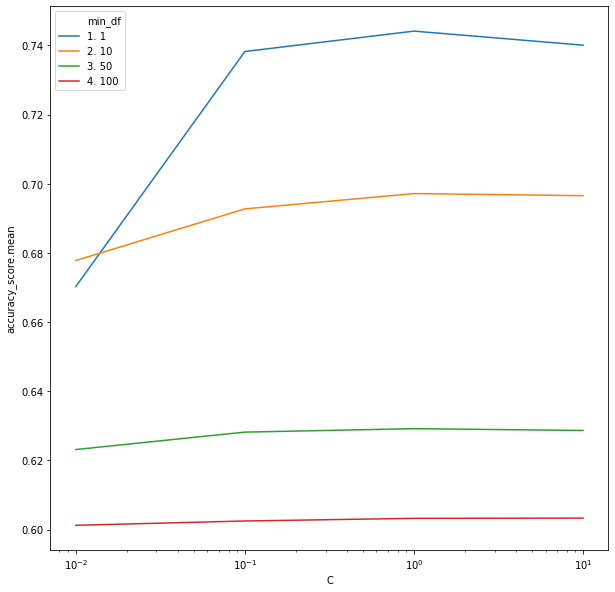

In [124]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
sns.lineplot('C','accuracy_score.mean',hue = 'min_df',data = svm, ax = ax)
plt.xscale('log')
plt.show()

In [132]:
pipe = Pipeline([("vectorizer", TfidfVectorizer()), 
                 ("classifier", LinearSVC())])
pipe.fit(data['lemmatized'], data['source'])
results = dict()
for df in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, dtype = dtypes, filter_fun = filter_fun)):
    ypred = pipe.predict(df['lemmatized'])
    metrics = ["accuracy_score","f1_score", "roc_auc_score"]
    results[df['day'].unique()[0]] = {metric:eval(metric)(df['source'], ypred) for metric in metrics}

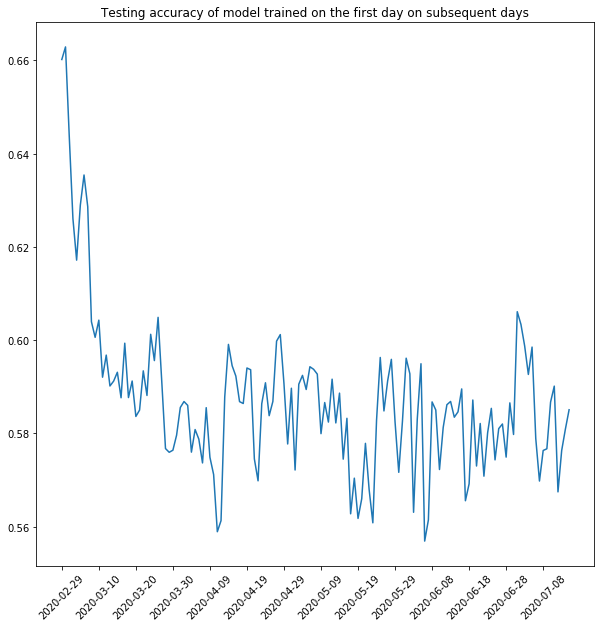

In [148]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
dates = list(results.keys())[1:]
accuracies = [w['accuracy_score'] for w in results.values()][1:]
ax.plot(dates, accuracies)
ax.xaxis.set_tick_params(rotation = 45)
ax.xaxis.set_ticks(np.arange(len(dates), step = 10))
ax.set_title('Testing accuracy of model trained on the first day on subsequent days')
plt.show()

In [117]:
if run_models:
    svm = kfold_model(X, Y, model = LinearSVC(max_iter = 10000, penalty = "l2"),
                  n_splits = 5, 
                  metrics = ["accuracy_score","precision_score","recall_score", "roc_auc_score"])
    print(svm)

In [128]:
def grid_search(X, Y, model, n_splits, params, metrics, verbose = True):
    ks, vs = zip(*params.items()) #ks - list of parameter names. vs - list of their values
    params = [dict(zip(ks, v)) for v in product(*vs)] #get a list of dictionaries of all combinations
    for i, param in enumerate(params):
        if verbose:
            print(f"\rIteration {i+1} out of {len(params)}. Testing params: {param}", end = "")
        clf = model(**param) #call model with params from param
        res = kfold_model(X,Y,n_splits = n_splits, model = clf, metrics = metrics) #run model and get results
        for k, v in res.items(): #compute stats
            params[i][k + "_mean"] = np.mean(v)
            params[i][k + "_std"] = np.std(v)
    return params

In [130]:
if run_models:
    params = {"C":[10**i for i in range(-3, 3)]}
    grid_svm = grid_search(X, Y, n_splits = 5, params = params, model = LinearSVC,
                       metrics = ["accuracy_score","precision_score","recall_score", "roc_auc_score"])
    print(grid_svm)

Iteration 6 out of 6. Testing params: {'C': 100}}}

/home/piotr/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/piotr/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/piotr/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/piotr/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/piotr/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

#### C = 1 offers the best performance

# Try LSTM:

In [13]:
#import NN
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from tqdm.notebook import tqdm 


#define cuda stuff
USE_CUDA = torch.cuda.is_available() 
def cuda(v):
    if USE_CUDA:
        return v.cuda()
    return v
def toTensor(v,dtype = torch.float,requires_grad = False):       
    return cuda(Variable(torch.tensor(v)).type(dtype).requires_grad_(requires_grad))
def toNumpy(v):
    if USE_CUDA:
        return v.detach().cpu().numpy()
    return v.detach().numpy()



def data_split(X,Y,train_index,test_index):
    #takes numpy array as input and train-test indexes as input
    #returns train and test tensor datasets 
    
    #training:
    xtr = toTensor(X[train_index], dtype = torch.long)
    ytr = toTensor(Y[train_index])
    train_tensor_dataset = torch.utils.data.TensorDataset(xtr,ytr) 
    
    #testing:
    xts = toTensor(X[test_index], dtype = torch.long)
    yts = toTensor(Y[test_index])
    test_tensor_dataset = torch.utils.data.TensorDataset(xts,yts) 
    
    return train_tensor_dataset, test_tensor_dataset

Set processing params:

In [14]:
max_words = 5000
seq_len = 50

Preprocess data:

In [15]:
Xtr, Xts, Ytr, Yts = train_test_split(X, Y)
lstm_tokenizer = Tokenizer(num_words = max_words, split = " ", filters = " ")
lstm_tokenizer.fit_on_texts(Xtr)
Ytr = pd.get_dummies(Ytr).values; Yts = pd.get_dummies(Yts).values
Xtr = [list(chain.from_iterable(lstm_tokenizer.texts_to_sequences(tweet))) for tweet in Xtr]
Xtr = pad_sequences(Xtr, maxlen = seq_len)

Get the embedding matrix:

In [19]:
emb_mat = np.zeros((max_words, 100))
with open("/home/piotr/nlp/glove_100_3_polish.txt") as f:
    for line in f:
        elements = line.split()
        if elements[0] in lstm_tokenizer.word_index and lstm_tokenizer.word_index[elements[0]] <= max_words:
            emb_mat[lstm_tokenizer.word_index.get(elements[0])-1] = elements[1:]
print(np.sum(emb_mat.any(axis = 1)))

4904


In [20]:
#convert embedding matrix to pytorch
emb_mat_trch = toTensor(emb_mat)
#get data as dataloaders:
Xtr = toTensor(Xtr, dtype = torch.long)
Ytr = toTensor(Ytr)
train_tensor_dataset = torch.utils.data.TensorDataset(Xtr,Ytr) 

In [47]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(emb_mat_trch)
        self.lstm = nn.LSTM(input_size = 100, hidden_size = 50, batch_first = True)
        self.clf = nn.Sequential(
            nn.Linear(50, 50),
            nn.ReLU(), 
            nn.Linear(50, 2))
        
    def forward(self, x):
        out = self.embedding(x)
        _, (out, _) = self.lstm(out)
        out = self.clf(out)
        out = nn.functional.softmax(out.view(-1, 2), dim = 0)
        return out

Train:

<IPython.core.display.Javascript object>


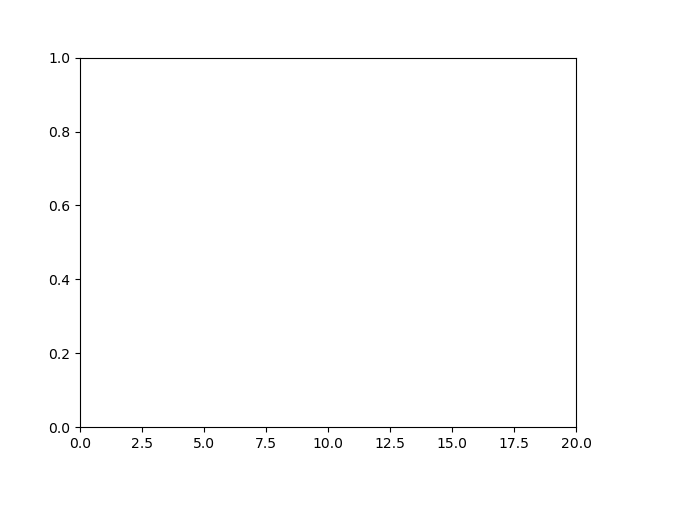

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 Mean training loss 0.6934837102890015

  5%|▌         | 1/20 [03:15<1:01:51, 195.36s/it]

Epoch 1 Mean training loss 0.6935669779777527

  5%|▌         | 1/20 [03:56<1:14:50, 236.34s/it]

Epoch 1 Mean training loss 0.6935663819313049

KeyboardInterrupt: 

In [49]:
%matplotlib notebook
num_epochs = 20
batch_size = 64
learning_rate = 0.1
run_nn = False
model = cuda(Net())

#loader for training
train_loader = torch.utils.data.DataLoader(dataset = train_tensor_dataset, 
                                           batch_size = batch_size, 
                                           shuffle = True)
#loader for testing
"""
test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, #do one batch for now
                                          shuffle=False)
"""




# Loss and Optimizer
criterion = nn.MultiLabelSoftMarginLoss()  #Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#history.append({"train":[],"validation":[], "predictions":[]}) #track values for each cv-fold
history = {"epoch":[],
           "train":[]}


fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(0, num_epochs);
ax.set_ylim(0, 1);
plt.ion()

fig.show()
fig.canvas.draw()

if run_nn:

    for epoch in trange(num_epochs):
            model.train() #set the mode to training
            train_loss = []
            validation_loss = []
            for inputs, labels in train_loader:  #pick a batch
                # Pass to cuda
                inputs = cuda(inputs)
                labels = cuda(labels)

                # Forward + Backward + Optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels) #calculate loss
                optimizer.zero_grad()  # zero the gradient buffer
                loss.backward()
                optimizer.step()
                train_loss.append(toNumpy(loss)) #save loss
                torch.cuda.empty_cache()
                print("\rEpoch {} Mean training loss {}".format(epoch, np.mean(train_loss)), end = "")
            history["train"].append(np.mean(train_loss))
            history["epoch"].append(epoch)
            ax.plot(history["epoch"], history["train"])
            fig.canvas.draw()
else:
    print("Not running")